In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
number_of_rows_per_language = 500
languages = ['Polish', 'Slovak', 'French', 'English', 'German', 'Finnish', 'Hungarian']

train_set = pd.DataFrame()
test_set = pd.DataFrame()

for language in languages:
    data = pd.read_csv(f'data/processed/{language}.csv', nrows=number_of_rows_per_language)
    train_data = data.sample(frac=.85)
    test_data = data.drop(index=train_data.index)

    train_set = pd.concat([train_set, train_data], ignore_index=True)
    test_set = pd.concat([test_set, test_data], ignore_index=True)

train_set.head()

,text,lang,letters,a,b,c,d,e,f,g,...,q,r,s,t,u,v,w,x,y,z
0,"I nazwał imię jego Noe, mówiąc: Ten nas pocies...",Polish,inazwałimięjegonoemówiąctennaspocieszyzpracyna...,7,1,4,0,7,0,1,...,0,6,5,4,0,0,2,0,5,9
1,Było tedy wszystkich dni Enosowych dziewięć se...,Polish,byłotedywszystkichdnienosowychdziewięćsetlatip...,3,1,2,3,4,0,0,...,0,1,4,5,1,0,3,0,4,2
2,"Zatem rzekł Abram: Panie Boże, po czemże pozna...",Polish,zatemrzekłabrampaniebożepoczemżepoznamiżjąodzi...,5,2,2,2,7,0,0,...,0,2,0,1,0,0,0,0,0,7
3,"Arfachsad zaś spłodził Selecha, a Selech spłod...",Polish,arfachsadzaśspłodziłselechaaselechspłodziłhebera,7,1,3,3,6,1,0,...,0,2,5,0,0,0,0,0,0,3
4,"Potem rzekł Bóg do Abrahama: Sarai, żony twoje...",Polish,potemrzekłbógdoabrahamasaraiżonytwojejniebędzi...,13,4,0,3,10,0,1,...,0,5,4,2,0,0,2,0,1,5


In [3]:
train_set.drop(columns=['text', 'letters'], inplace=True)

In [4]:
language_to_code = {lang: code for code, lang in enumerate(languages)}
language_to_code

{'Polish': 0,
 'Slovak': 1,
 'French': 2,
 'English': 3,
 'German': 4,
 'Finnish': 5,
 'Hungarian': 6}

In [5]:
train_set['code'] = train_set.lang.map(lambda x: language_to_code[x])
test_set['code'] = test_set.lang.map(lambda x: language_to_code[x])
train_set = train_set.sample(frac=1)

In [6]:
class Perceptron:
    def __init__(self, number_of_inputs: int, learning_rate: float):
        self.weights_vector = np.random.random(number_of_inputs)
        self.theta = np.random.random()
        self.alpha = learning_rate

    def predict(self, vector: np.ndarray, return_net: bool=False):
        net = np.sum(self.weights_vector * vector) - self.theta

        if return_net:
            return net

        return int(net > 0)


    def train(self, vector: np.ndarray, expected_outcome: int) -> None:
        extended_weights = np.append(self.weights_vector, self.theta)
        extended_vector = np.append(vector, -1)

        new_weights = extended_weights + (expected_outcome - self.predict(vector)) * self.alpha * extended_vector
        self.theta = new_weights[-1]
        self.weights_vector = new_weights[:-1]

    def __str__(self) -> str:
        return f'weights={self.weights_vector}; theta={self.theta}'

In [7]:
class SingleLayerNeuralNetwork:
    def __init__(self, number_of_categories: int, number_of_inputs: int, learning_rate: float):
        self.perceptrons = [Perceptron(number_of_inputs, learning_rate) for _ in range(number_of_categories)]

    def predict(self, X: np.ndarray):
        scores = [p.predict(X, return_net=True) for p in self.perceptrons]
        return np.argmax(scores)

    def train(self, vector: np.ndarray, expected_outcome: int):
        for index, perceptron in enumerate(self.perceptrons):
            perceptron.train(vector, int(expected_outcome == index))

In [8]:
class NN:
    def __init__(self, inputs: int, categories: int, learning_rate: float):
        self.inputs = inputs
        self.categories = categories
        self.weights : np.ndarray = np.random.random((inputs, categories))
        self.t = np.random.random(categories)
        self.alpha = learning_rate

    def predict(self, x: np.ndarray):
        net = x @ self.weights
        return np.argmax(net)

    def fit(self, x, y):
        net = x @ self.weights - self.t
        expected_outcomes = np.zeros(self.categories)
        expected_outcomes[y] = 1
        results = (net > 0).astype(int)
        x_matrix = np.tile(x, (self.categories, 1)).transpose()
        x_matrix = np.append(x_matrix,
                             np.array([-1] * self.categories).reshape(1, self.categories),
                             axis=0)
        weights_extended = np.append(self.weights, [self.t], axis=0)

        final = weights_extended + x_matrix @ np.diag((expected_outcomes - results) * self.alpha)
        self.t = final[-1]
        self.weights = final[:-1]



In [9]:
def test_neural_network(nn: SingleLayerNeuralNetwork, data: np.ndarray, expected_values: np.ndarray) -> float:
    results = np.array([])

    for vector in data:
        results = np.append(results, nn.predict(vector))

    return sum(results == expected_values) / len(expected_values)

Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

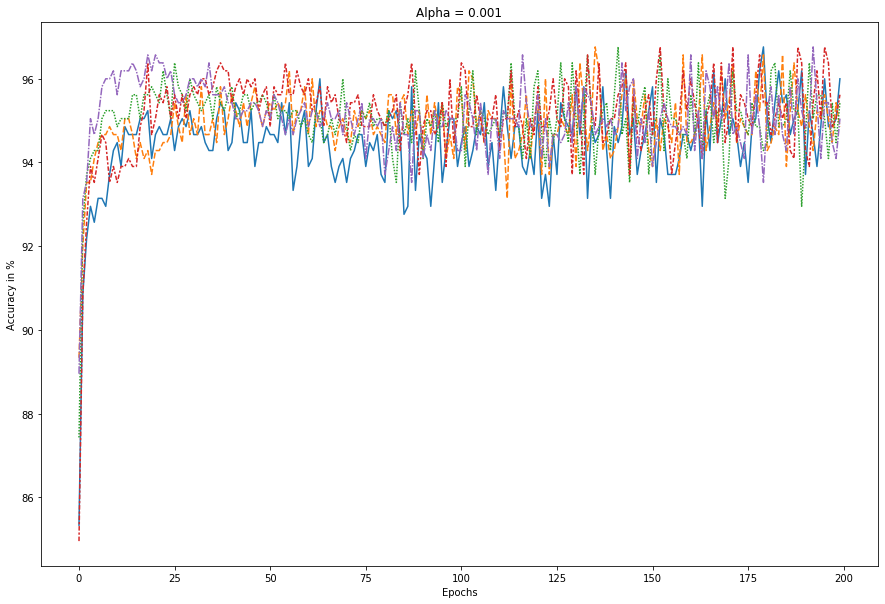

In [10]:
alpha = 0.001
epochs = 200
number_of_iterations = 5

data : np.ndarray = train_set.loc[:, 'a':'z'].to_numpy()
expected_values = train_set['code'].to_numpy()

test_data = test_set.loc[:, 'a':'z'].to_numpy()
test_expected_values = test_set['code'].to_numpy()

results = pd.DataFrame(index=range(epochs))
networks = []

for iteration in tqdm(range(number_of_iterations), desc='Iterations'):
    nn = NN(inputs=data.shape[1], categories=len(languages), learning_rate=alpha)

    iteration_results = np.array([])

    for epoch in range(epochs):

        for vector, expected_value in zip(data, expected_values):
            nn.fit(vector, expected_value)

        test_result = test_neural_network(nn, test_data, test_expected_values)
        iteration_results = np.append(iteration_results, test_result * 100)

    networks.append(nn)
    results[iteration] = iteration_results

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.lineplot(data=results, ax=ax)
ax.get_legend().remove()
plt.title(f'Alpha = {alpha}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy in %')
plt.savefig(f'figures/{";".join(languages)}-alpha{alpha}-epochs{epochs}.jpg')
plt.show()

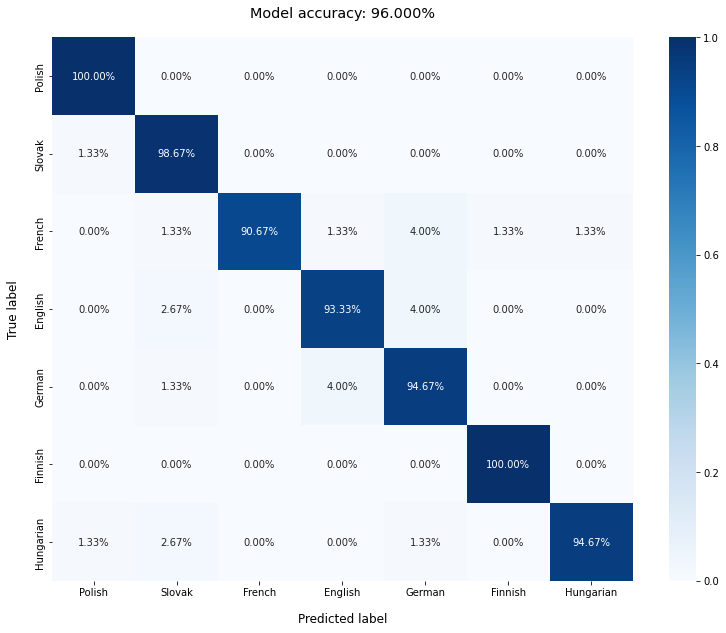

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score

best_network = networks[np.argmax(results.iloc[-1, :])]

y_true = test_expected_values
y_predicted = [best_network.predict(x) for x in test_data]

cm = confusion_matrix(y_true, y_predicted, normalize='true')
acc = accuracy_score(y_true, y_predicted)

cmdf = pd.DataFrame(cm)
cmdf.columns = languages
cmdf.index = languages

fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
sns.heatmap(cmdf, annot=True, fmt='.2%', cmap='Blues', ax=ax)
plt.title(f'Model accuracy: {acc:.3%}', fontsize='x-large', y=1.025)
plt.xlabel('Predicted label', fontsize='large', labelpad=15)
plt.ylabel('True label', fontsize='large', labelpad=15)
plt.savefig('figures/confusion-matrix.jpg')
plt.show()

In [13]:
from string import ascii_lowercase
text_en = """Sarin, mustard agent and chlorine gas have been used during the conflict. Numerous casualties led to an international reaction, especially the 2013 Ghouta attacks. A UN fact-finding mission was requested to investigate alleged chemical weapons attacks. In four cases the UN inspectors confirmed use of sarin gas.[138] In August 2016, a confidential report by the United Nations and the OPCW explicitly blamed the Syrian military of Bashar al-Assad for dropping chemical weapons (chlorine bombs) on the towns of Talmenes in April 2014 and Sarmin in March 2015 and ISIS for using sulfur mustard on the town of Marea in August 2015.[139] In 2016, Jaysh al-Islam rebel group had used chlorine gas or other agents against Kurdish militia and civilians in the Sheikh Maqsood neighborhood of Aleppo.[140]"""

text_de = """Als Krieg wird ein organisierter und unter Einsatz erheblicher Mittel mit Waffen und Gewalt ausgetragener Konflikt bezeichnet,[1][2] an dem planmäßig vorgehende Kollektive beteiligt sind. Ziel der beteiligten Kollektive ist es, ihre Interessen durchzusetzen. Der Konflikt soll durch Kampf und Erreichen einer Überlegenheit gelöst werden. Die dazu stattfindenden Gewalthandlungen greifen gezielt die körperliche Unversehrtheit gegnerischer Individuen an und führen so zu Tod und Verletzung. Neben Schäden an am Krieg aktiv Beteiligten entstehen auch immer Schäden, die entweder nicht direkt beabsichtigt sind oder Kriegstaktik („Verbrannte Erde“) sein können. Erstere werden heute euphemistisch als Kollateralschäden bzw. Begleitschäden bezeichnet. Krieg beschädigt oder zerstört sogar Infrastruktur und die Lebensgrundlagen der Kollektive. Eine einheitlich akzeptierte Definition des Krieges und seiner Abgrenzung zu anderen Formen bewaffneter Konflikte existiert nicht.[3]"""

text_pl = """Wojna – zorganizowany konflikt zbrojny między państwami, narodami lub grupami etnicznymi, religijnymi i społecznymi. Brak jest jednak jednoznacznej, powszechnie uznanej definicji wojny, której próby zdefiniowania podejmowane były już od starożytności. Cyceron zdefiniował wojnę jako rozstrzyganie sporu przy użyciu siły, według Hugo Grotiusa wojna to stan, w jakim znajdują się osoby toczące spór przy użyciu siły, której następstwem są niezliczone nieszczęścia, które spadają również na niewinnych ludzi. Carl von Clausewitz wojnę zdefiniował jako czyn polityczny, dalszy ciąg stosunków politycznych wyrażających się w akcie przemocy, mającym na celu zmuszenie przeciwnika, czyli doprowadzenie jego sił zbrojnych do stanu w którym nie będą zdolne do dalszej walki. Nowsze definicje nie uznają wojny za zjawisko czysto militarne, lecz totalne, łączące w sobie politykę wewnętrzną i zagraniczną, gospodarkę i działania wojenne. Na pojęcie wojny składają się zgodnie z nimi zjawiska społeczne, historyczne i klasowe, polegające na regulowaniu sporów i realizowaniu celów politycznych przez zastosowanie przemocy. Wojna to działania wojenne w rozumieniu operacji wojskowych, ale także stan prawny, w którym uznaje się istnienie wojny. W tym kontekście należy wojnę rozumieć jako konflikt z użyciem broni między państwami, blokami państw, narodami czy klasami społecznymi."""

text_fi = """Yleisesti sotaa tutkitaan ja määritellään joko sosio-poliittisena tai lakitieteellisenä ilmiönä. Ensimmäinen antaa sijaa tieteelliselle tutkimukselle, kun jälkimmäinen on tärkeä yhteiskunnallisista ja käytännöllisistä syistä. Ensimmäisen näkökulman mukaan sota voi tapahtua vain kahden tai useamman hallinnollisesti järjestäytyneen (heimon, kaupunkivaltion, kansallisvaltion, valtakunnan) osapuolen välillä, kun lakitieteellisestä näkökulmasta sota on laillinen olotila, joka tasa-arvoisesti mahdollistaa kahden tai useamman ryhmän välisen aseellisesti käydyn konfliktin. Myös juridisesti asiaa lähestyvät painottavat hallinnollisuuden merkitystä, sillä kamppailu voidaan katsoa sodaksi vain jos sen osapuolia johdetaan poliittisesti järjestäytyneinä yksiköinä.[1]"""

text_fr = """Les États font la guerre aux autres États, pas aux individus ni aux familles qui les composent. Ainsi, la guerre est définie comme un acte de politique étrangère ou défensif de dernier recours après d'ultimes négociations de diplomatie.

Les guerres et leurs moyens sont juridiquement soumis à des règles d'honneur anciennes et tacitement admises, les lois de la guerre, devenues le fondement du droit international public. Celles-ci définissent les conditions de légitimité, le déroulement, et les moyens licites des guerres. Une guerre est précédée d'une revendication ou d'un casus belli, d'un ultimatum, puis d'une déclaration de guerre ; elle peut être suspendue par des trêves, un armistice ; elle se termine par la reddition d'une armée, la capitulation d'un gouvernement, puis la signature d'un traité accordant ou refusant les revendications initiales, le paiement de compensations, et le retour à l'état de paix.

La science de la conduite d'une guerre s'appelle la stratégie, celle de gagner les batailles la tactique, celle des causes et des conséquences des conflits, la polémologie (venant du grec polemos qui signifie la guerre et de son suffixe logos qui veut dire l'étude. La polémologie est donc l'étude de la guerre)."""

text = text_de

text = ''.join(filter(str.isalpha, text.lower().split()))
data = [text.count(l)/len(text) for l in ascii_lowercase]

langs_reversed = {v: k for k, v in language_to_code.items()}
langs_reversed[best_network.predict(data)]

'German'